# プロダクト開発演習

## テーマ
高解像度の画像への変換

## 目的
低解像度画像を高解像度画像にするアップサンプリング

## データセット
cifar10,cifar100

## 簡単な設計
CIFAR-10 で低解像→高解像

- 入力：32×32 を一旦 16×16 に縮小し、32×32 に整形した **低解像の画像（LR）**
- 教師：データセットに入っている **32×32 の画像（HR）**
- 目的：**LR → HR** を再構成（MSE を最小化、PSNR で評価）

## 1. ライブラリの読み込み

In [2]:
import sys

import os, math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 乱数シード固定（再現性）
# 毎回同じ挙動とするため。比較実験をした結果を安定して得るため
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# デバイス設定(CPU or GPU) ※手元はCPU環境だけど一応
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

## 2. 設定（ハイパーパラメータ）

In [3]:

CFG = dict(
    batch_size=128,
    # epochs=15,              # 本当は15以上は欲しいけど、スペックが足りないので実装時は3
    epochs=3,              # 最小構成なので短め
    lr=2e-3,
    weight_decay=1e-5,
    low_size=16,
    high_size=32,
    save_dir="./runs_baseline_ipynb"
)
os.makedirs(CFG["save_dir"], exist_ok=True)
CFG

{'batch_size': 128,
 'epochs': 15,
 'lr': 0.002,
 'weight_decay': 1e-05,
 'low_size': 16,
 'high_size': 32,
 'save_dir': './runs_baseline_ipynb'}

## 3. データ前処理（CIFAR-10 を LR/HR に分ける）

In [4]:

to_tensor = transforms.ToTensor()
trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=to_tensor)
testset  = datasets.CIFAR10(root="./data", train=False, download=True, transform=to_tensor)

train_loader = DataLoader(trainset, batch_size=CFG["batch_size"], shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(testset,  batch_size=CFG["batch_size"], shuffle=False, num_workers=2, pin_memory=True)

def make_low_res(x, low=16, high=32):
    # x: (B,3,32,32) in [0,1]
    lr_small = F.interpolate(x, size=(low, low), mode="bilinear", align_corners=False)
    lr_up    = F.interpolate(lr_small, size=(high, high), mode="bilinear", align_corners=False)
    return lr_up, x  # (入力LR(拡大), 教師HR)


## 4. モデル（最小構成：BN/Skip なし、Upsample+Conv）

In [5]:

def conv_block(ic, oc):
    return nn.Sequential(nn.Conv2d(ic, oc, 3, padding=1), nn.ReLU(inplace=True))

class CAE_Baseline(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder: Conv→Conv→Pool→Conv（中間層3層以上）
        self.e1 = conv_block(3, 64)    # 32x32
        self.e2 = conv_block(64, 128)  # 32x32
        self.pool = nn.MaxPool2d(2)    # 32→16
        self.e3 = conv_block(128, 128) # 16x16 (bottleneck)

        # Decoder: Upsample(×2) + Conv（転置畳み込みは使わない最小構成）
        self.up = nn.Upsample(scale_factor=2, mode="nearest")  # 16→32
        self.d1 = conv_block(128, 64)
        self.out = nn.Conv2d(64, 3, kernel_size=1)  # 32x32, 3ch

    def forward(self, x):
        x = self.e1(x)
        x = self.e2(x)
        x = self.pool(x)
        x = self.e3(x)
        x = self.up(x)
        x = self.d1(x)
        y = torch.sigmoid(self.out(x))  # 出力を[0,1]
        return y

model = CAE_Baseline().to(DEVICE)
sum(p.numel() for p in model.parameters())/1e6


0.297219

## 5. 損失・最適化・指標（MSE / PSNR）

In [6]:

criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])

def psnr_from_mse(mse):
    if mse <= 1e-12: return 99.0
    return 10 * math.log10(1.0 / mse)  # 入出力を[0,1]前提


## 6. 学習ループ & 検証

In [7]:

train_losses, val_losses, val_psnrs = [], [], []

@torch.no_grad()
def validate():
    model.eval()
    total_loss, total_psnr, n = 0.0, 0.0, 0
    for x, _ in test_loader:
        x = x.to(DEVICE)
        lr, hr = make_low_res(x, CFG["low_size"], CFG["high_size"])
        sr = model(lr)
        loss = criterion(sr, hr)
        b = x.size(0)
        total_loss += loss.item() * b
        total_psnr += psnr_from_mse(loss.item()) * b
        n += b
    return total_loss / n, total_psnr / n if (val_psnrs := (total_psnr / n)) else (total_loss / n, 0.0)

best = float("inf")
for ep in range(1, CFG["epochs"] + 1):
    model.train()
    run_loss, m = 0.0, 0
    for x, _ in train_loader:
        x = x.to(DEVICE)
        lr, hr = make_low_res(x, CFG["low_size"], CFG["high_size"])
        sr = model(lr)
        loss = criterion(sr, hr)
        optim.zero_grad(); loss.backward(); optim.step()
        run_loss += loss.item() * x.size(0); m += x.size(0)

    tr = run_loss / m
    va, va_psnr = validate()
    train_losses.append(tr); val_losses.append(va); val_psnrs.append(va_psnr)
    print(f"[{ep:02d}/{CFG['epochs']}] train={tr:.4f}  val={va:.4f}  PSNR={va_psnr:.2f}dB")

    if va < best:
        best = va
        torch.save(model.state_dict(), os.path.join(CFG["save_dir"], "best_baseline.pth"))


/app/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/pytorch/third_party/ideep/mkl-dnn/src/cpu/aarch64/xbyak_aarch64/src/util_impl_linux.h, 451: Can't read MIDR_EL1 sysfs entry


[01/15] train=0.0060  val=0.0027  PSNR=25.75dB
[02/15] train=0.0026  val=0.0024  PSNR=26.23dB
[03/15] train=0.0024  val=0.0024  PSNR=26.19dB
[04/15] train=0.0024  val=0.0022  PSNR=26.49dB
[05/15] train=0.0023  val=0.0022  PSNR=26.55dB
[06/15] train=0.0023  val=0.0022  PSNR=26.60dB


KeyboardInterrupt: 

## 7. 学習曲線の可視化（提出用アーティファクト）

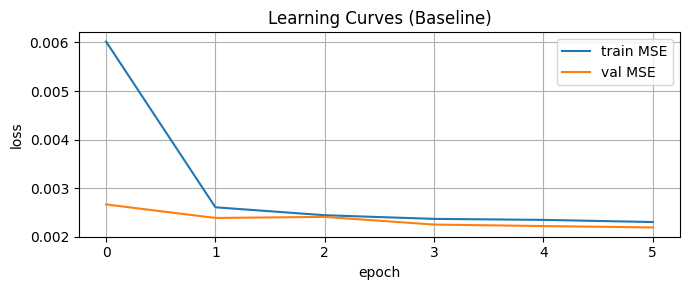

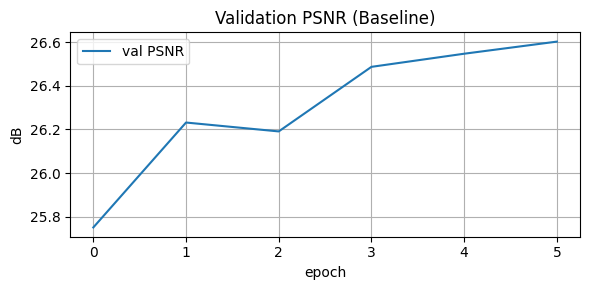

['best_baseline.pth',
 'psnr_baseline.png',
 'demo_grid_baseline.png',
 'curves_baseline.png']

In [ ]:
plt.figure(figsize=(7,3))
plt.plot(train_losses, label="train MSE"); plt.plot(val_losses, label="val MSE")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Learning Curves")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(CFG["save_dir"], "curves_baseline.png"))
plt.show()  # 画像を表示

plt.figure(figsize=(6,3))
plt.plot(val_psnrs, label="val PSNR")
plt.xlabel("epoch"); plt.ylabel("dB"); plt.title("Validation PSNR")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(CFG["save_dir"], "psnr_baseline.png"))
plt.show()  # 画像を表示

os.listdir(CFG["save_dir"])

## 8. 予測デモ（LR → 出力SR → HR を1枚に）

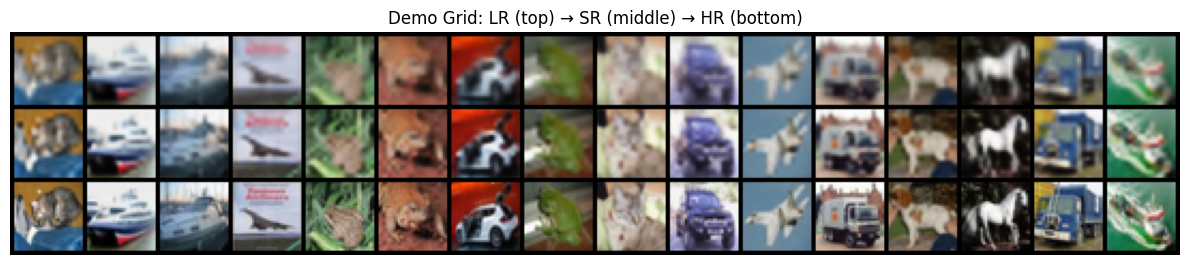

'./runs_baseline_ipynb/demo_grid_baseline.png'

In [ ]:
@torch.no_grad()
def save_demo_grid():
    model.load_state_dict(torch.load(os.path.join(CFG["save_dir"], "best_baseline.pth"), map_location=DEVICE))
    model.eval()
    x, _ = next(iter(test_loader))
    x = x[:16].to(DEVICE)
    lr, hr = make_low_res(x, CFG["low_size"], CFG["high_size"])
    sr = model(lr)
    grid = torch.cat([lr.cpu(), sr.cpu(), hr.cpu()], dim=0)  # 16*3=48枚 (上:LR 中:SR 下:HR)
    out_path = os.path.join(CFG["save_dir"], "demo_grid_baseline.png")
    utils.save_image(grid, out_path, nrow=16)
    return out_path

demo_path = save_demo_grid()

# 画像を表示
# 上から下にかけて、画像の解像度が上がっていれば成功
from PIL import Image
img = Image.open(demo_path)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.title('Demo Grid: LR (top) → SR (middle) → HR (bottom)')
plt.tight_layout()
plt.show()

demo_path

<!-- Best is kernel=4, last dropout? -->